In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string
import re

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from collections import Counter
from string import punctuation

In [2]:
#nltk.download('stopwords')

In [3]:
twitters = pd.read_csv('training.txt', sep = '\t', names=['label', 'tweet'])

In [4]:
twitters.head()

,label,tweet
0,1,The Da Vinci Code book is just awesome.
1,1,this was the first clive cussler i've ever rea...
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly did...


In [5]:
# check the number of positive vs. negative labeled tweets
pos = twitters['label'][twitters.label == 0]
neg = twitters['label'][twitters.label == 1]

print('number of positve tagged sentences is:  {}'.format(len(pos)))
print('number of negative tagged sentences is: {}'.format(len(neg)))
print('total length of the data is:            {}'.format(twitters.shape[0]))

number of positve tagged sentences is:  2975
number of negative tagged sentences is: 3943
total length of the data is:            6918


In [6]:
twitters.describe()

,label
count,6918.000000
mean,0.569962
std,0.495117
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [7]:
twitters.groupby('label').describe()

tweet                                  
      count unique                   top freq
label                                        
0      2975    559  I hate Harry Potter.   85
1      3943    732  I love Harry Potter.  167

In [8]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
twitters['word count'] = twitters['tweet'].apply(word_count)
twitters.head(10)

,label,tweet,word count
0,1,The Da Vinci Code book is just awesome.,8
1,1,this was the first clive cussler i've ever rea...,23
2,1,i liked the Da Vinci Code a lot.,8
3,1,i liked the Da Vinci Code a lot.,8
4,1,I liked the Da Vinci Code but it ultimatly did...,15
5,1,that's not even an exaggeration ) and at midni...,24
6,1,"I loved the Da Vinci Code, but now I want some...",14
7,1,"i thought da vinci code was great, same with k...",11
8,1,The Da Vinci Code is actually a good movie...,9
9,1,I thought the Da Vinci Code was a pretty good ...,11


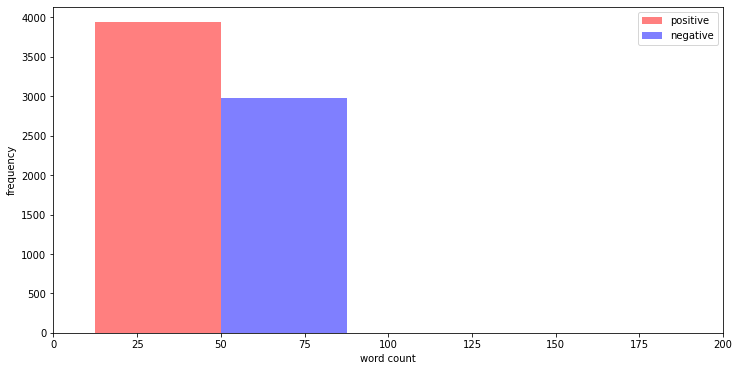

In [9]:
# plot word count distribution for both positive and negative sentiments
x = twitters['word count'][twitters.label == 1]
y = twitters['word count'][twitters.label == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,200)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [10]:
# get most common words in training dataset
all_words = []
for line in list(twitters['tweet']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

[('i', 4559),
 ('the', 3221),
 ('and', 2148),
 ('harry', 2088),
 ('vinci', 2001),
 ('da', 1998),
 ('brokeback', 1996),
 ('code', 1628),
 ('love', 1540),
 ('is', 1512)]

In [11]:
# get top-10 words more frequent with positive labels in training dataset
pos_words = []
for line in list(twitters['tweet'][twitters.label == 1]):
    pwords = line.split()
    for pword in pwords:
        pos_words.append(pword.lower())
    
    
Counter(pos_words).most_common(10)

[('i', 3142),
 ('the', 1836),
 ('love', 1532),
 ('harry', 1085),
 ('vinci', 1000),
 ('da', 999),
 ('brokeback', 999),
 ('mission', 997),
 ('is', 987),
 ('and', 954)]

In [12]:
# get top-10 words more frequent with negative labels in training dataset
neg_words = []
for line in list(twitters['tweet'][twitters.label == 0]):
    nwords = line.split()
    for nword in nwords:
        neg_words.append(nword.lower())
    
    
Counter(neg_words).most_common(10)

[('i', 1417),
 ('the', 1385),
 ('and', 1194),
 ('harry', 1003),
 ('vinci', 1001),
 ('da', 999),
 ('brokeback', 997),
 ('code', 946),
 ('mountain', 716),
 ('hate', 571)]

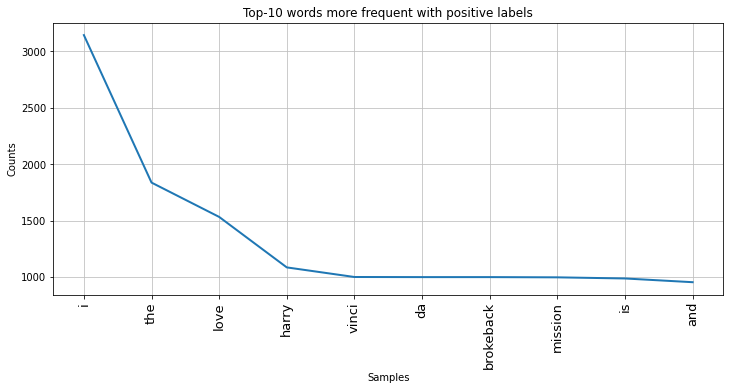

Text(0.5, 1.0, 'log-log plot of words frequency with positive labels')

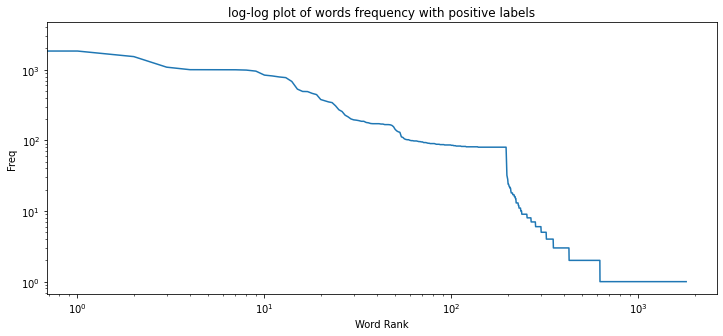

In [13]:
# plot word frequency distribution of first few words with positive labels
plt.figure(figsize=(12,5))
plt.title('Top-10 words more frequent with positive labels')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(pos_words)
fd.plot(10,cumulative=False)

# log-log plot with positive labels
word_counts = sorted(Counter(pos_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency with positive labels')

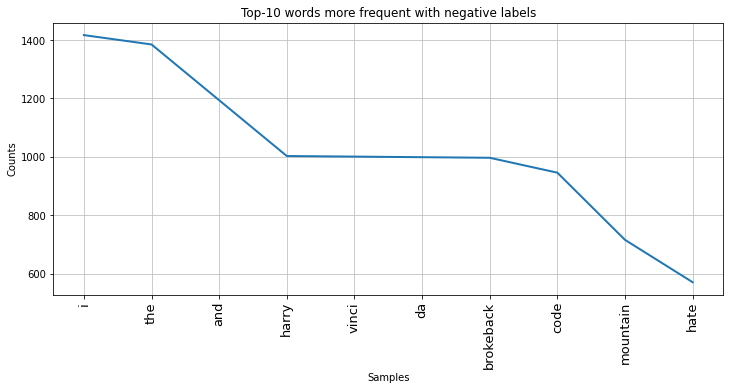

Text(0.5, 1.0, 'log-log plot of words frequency with negative labels')

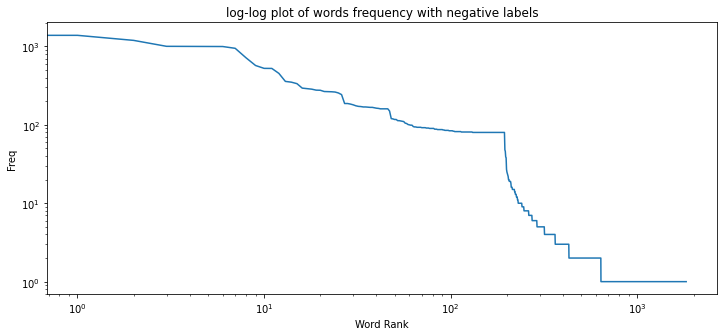

In [14]:
# plot word frequency distribution of first few words with negative labels
plt.figure(figsize=(12,5))
plt.title('Top-10 words more frequent with negative labels')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(neg_words)
fd.plot(10,cumulative=False)

# log-log plot with negative labels
word_counts = sorted(Counter(neg_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency with negative labels')

## Tokenization

In [15]:
def text_process(twitt):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    no_punc = [char for char in twitt if char not in string.punctuation]

    # Join the characters again to form the string.
    no_punc = ''.join(no_punc)
    
    # Now just remove any stopwords
    return [word for word in no_punc.split() if word.lower() not in stopwords.words('english')]

#def remove_words(word_list):
    #remove = ['harry','potter','code','da','vinci','brokeback','mountain','mission','movie','movies']
    #return [w for w in word_list if w not in remove]

In [16]:
twitters.head()

,label,tweet,word count
0,1,The Da Vinci Code book is just awesome.,8
1,1,this was the first clive cussler i've ever rea...,23
2,1,i liked the Da Vinci Code a lot.,8
3,1,i liked the Da Vinci Code a lot.,8
4,1,I liked the Da Vinci Code but it ultimatly did...,15


In [17]:
twitters['tweet_tp'] = twitters['tweet'].apply(text_process)

In [18]:
twitters.head()

,label,tweet,word count,tweet_tp
0,1,The Da Vinci Code book is just awesome.,8,"[Da, Vinci, Code, book, awesome]"
1,1,this was the first clive cussler i've ever rea...,23,"[first, clive, cussler, ive, ever, read, even,..."
2,1,i liked the Da Vinci Code a lot.,8,"[liked, Da, Vinci, Code, lot]"
3,1,i liked the Da Vinci Code a lot.,8,"[liked, Da, Vinci, Code, lot]"
4,1,I liked the Da Vinci Code but it ultimatly did...,15,"[liked, Da, Vinci, Code, ultimatly, didnt, see..."


In [19]:
# most common words in twitter dataset
all_words = []
for ls in twitters['tweet_tp']:
    words = [w for w in ls]
    for word in words:
        all_words.append(word.lower())
        
# most common words in twitter dataset
pos_words = []
for ls in twitters['tweet_tp'][twitters.label == 1]:
    pwords = [w for w in ls]
    for pword in pwords:
        pos_words.append(pword.lower())        

# most common words in twitter dataset
neg_words = []
for ls in twitters['tweet_tp'][twitters.label == 0]:
    nwords = [w for w in ls]
    for nword in nwords:
        neg_words.append(nword.lower())       

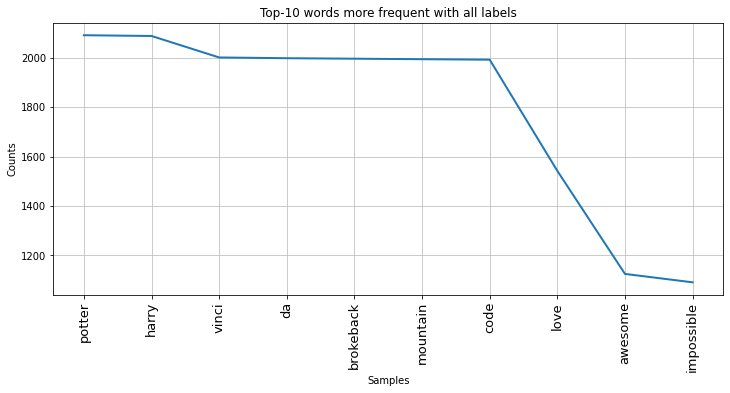

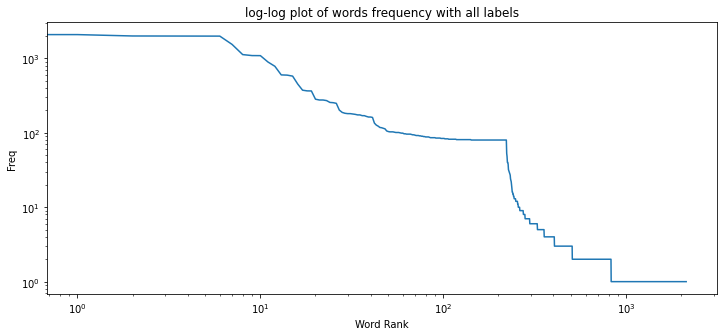

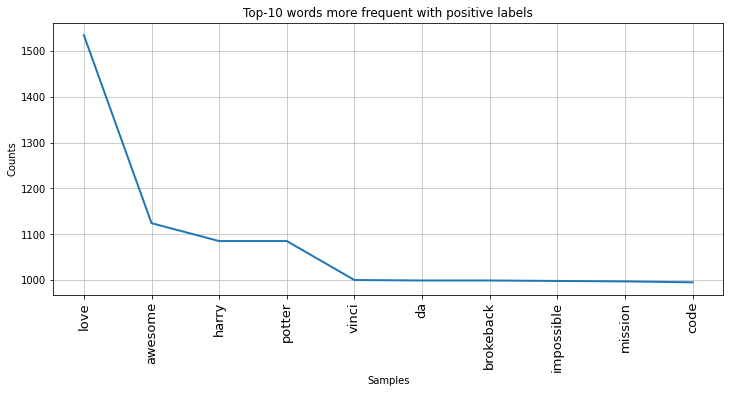

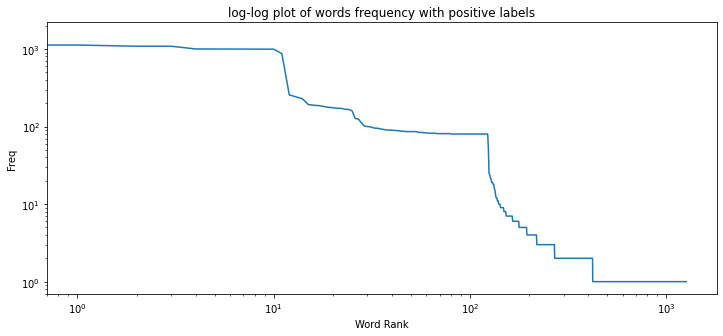

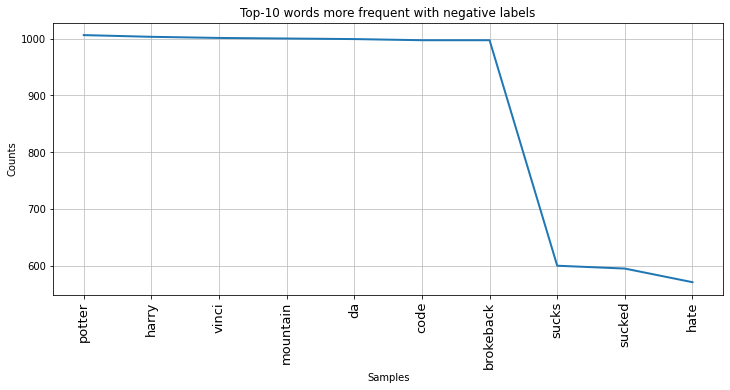

Text(0.5, 1.0, 'log-log plot of words frequency with negative labels')

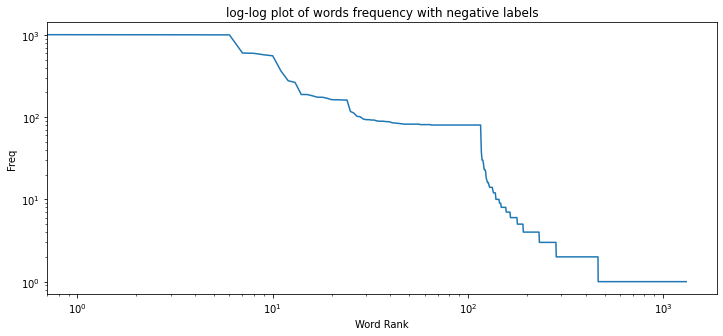

In [20]:
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top-10 words more frequent with all labels')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(10,cumulative=False)

# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency with all labels')

# plot word frequency distribution of first few words in positive labels
plt.figure(figsize=(12,5))
plt.title('Top-10 words more frequent with positive labels')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(pos_words)
fd.plot(10,cumulative=False)

# log-log of all words in positive labels
word_counts = sorted(Counter(pos_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency with positive labels')

# plot word frequency distribution of first few words in negative labels
plt.figure(figsize=(12,5))
plt.title('Top-10 words more frequent with negative labels')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(neg_words)
fd.plot(10,cumulative=False)

# log-log of all words in negative labels
word_counts = sorted(Counter(neg_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency with negative labels')

## Vectorization

In [21]:
bagofwords_transformer = CountVectorizer(analyzer=text_process).fit(twitters['tweet'])

In [22]:
print(len(bagofwords_transformer.vocabulary_))

2350


In [24]:
tweet5 = twitters['tweet'][4]

In [25]:
print(tweet5)

I liked the Da Vinci Code but it ultimatly didn't seem to hold it's own.


In [26]:
bow5 = bagofwords_transformer.transform([tweet5])
print(bow5)
print(bow5.shape)

  (0, 151)	1
  (0, 180)	1
  (0, 634)	1
  (0, 1051)	1
  (0, 1388)	1
  (0, 1549)	1
  (0, 1947)	1
  (0, 2207)	1
(1, 2350)


In [27]:
print(bagofwords_transformer.get_feature_names()[151])
print(bagofwords_transformer.get_feature_names()[180])
print(bagofwords_transformer.get_feature_names()[634])
print(bagofwords_transformer.get_feature_names()[1051])
print(bagofwords_transformer.get_feature_names()[1388])
print(bagofwords_transformer.get_feature_names()[1549])
print(bagofwords_transformer.get_feature_names()[1947])
print(bagofwords_transformer.get_feature_names()[2207])

Code
Da
Vinci
didnt
hold
liked
seem
ultimatly


In [28]:
twitters_bow = bagofwords_transformer.transform(twitters['tweet'])

In [29]:
print('Shape of Sparse Matrix: ', twitters_bow.shape)
print('Amount of Non-Zero occurences: ', twitters_bow.nnz)

Shape of Sparse Matrix:  (6918, 2350)
Amount of Non-Zero occurences:  46028


In [30]:
sparsity = (100.0 * twitters_bow.nnz / (twitters_bow.shape[0] * twitters_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


### TF-IDF

In [31]:
tfidf_transformer = TfidfTransformer().fit(twitters_bow)
tfidf5 = tfidf_transformer.transform(bow5)
print(tfidf5)

  (0, 2207)	0.49164560211161784
  (0, 1947)	0.49164560211161784
  (0, 1549)	0.2808852599058391
  (0, 1388)	0.4698565796960789
  (0, 1051)	0.4000352670868803
  (0, 634)	0.137309529420294
  (0, 180)	0.13734632390404936
  (0, 151)	0.13842447276291386


In [32]:
print(tfidf_transformer.idf_[bagofwords_transformer.vocabulary_['code']])
print(tfidf_transformer.idf_[bagofwords_transformer.vocabulary_['code']])

3.7217291105478605
3.7217291105478605


In [33]:
twitters_tfidf = tfidf_transformer.transform(twitters_bow)
print(twitters_tfidf.shape)

(6918, 2350)


## Training a model

In [34]:
sentiment_detect_model = MultinomialNB().fit(twitters_tfidf, twitters['label'])

In [35]:
print('predicted:', sentiment_detect_model.predict(tfidf5)[0])
print('actual:', twitters['label'][4])

predicted: 1
actual: 1


## Model Evaluation

In [36]:
all_preds = sentiment_detect_model.predict(twitters_tfidf)
print(all_preds)

[1 1 1 ... 0 0 0]


In [37]:
print (classification_report(twitters['label'], all_preds))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2975
           1       0.98      1.00      0.99      3943

    accuracy                           0.99      6918
   macro avg       0.99      0.99      0.99      6918
weighted avg       0.99      0.99      0.99      6918



## Train Test Split

In [38]:
twt_train, twt_test, label_train, label_test = \
train_test_split(twitters['tweet'], twitters['label'], test_size=0.3)

print('train size:', len(twt_train))
print('test size:', len(twt_test))
print('dataset size:', len(twt_train) + len(twt_test))

train size: 4842
test size: 2076
dataset size: 6918


## Creating a Data Pipeline

In [39]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [40]:
pipeline.fit(twt_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x000001B6833FA5E0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [41]:
predictions = pipeline.predict(twt_test)

In [42]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       829
           1       0.99      0.97      0.98      1247

    accuracy                           0.98      2076
   macro avg       0.98      0.98      0.98      2076
weighted avg       0.98      0.98      0.98      2076



In [43]:
predictions

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [44]:
twt_test_noindex = twt_test.reset_index(drop=True)
print(twt_test_noindex)

0       He's like,'YEAH I GOT ACNE AND I LOVE BROKEBAC...
1                                Love the Da Vinci Code!(
2       Because I would like to make friends who like ...
3                              I love Brokeback Mountain.
4       Harry Potter is AWESOME I don't care if anyone...
                              ...                        
2071    He's like,'YEAH I GOT ACNE AND I LOVE BROKEBAC...
2072                           DA VINCI CODE IS AWESOME!!
2073    So as felicia's mom is cleaning the table, fel...
2074    we're gonna like watch Mission Impossible or H...
2075             Brokeback Mountain was an AWESOME movie.
Name: tweet, Length: 2076, dtype: object


In [46]:
twt_test_noindex[0]

"He's like,'YEAH I GOT ACNE AND I LOVE BROKEBACK MOUNTAIN '.."

In [47]:
for i, p in enumerate(predictions):
#     print(i)
    print (twt_test_noindex[i] + " - " + str(p))
    if i>5:
        break #to avoid a lot of printing and slowing down the notebook

He's like,'YEAH I GOT ACNE AND I LOVE BROKEBACK MOUNTAIN '.. - 1
Love the Da Vinci Code!( - 1
Because I would like to make friends who like the same things I like, and I really like Harry Potter, so I thought that joining a community like this would be a good start. - 1
I love Brokeback Mountain. - 1
Harry Potter is AWESOME I don't care if anyone says differently!.. - 1
Still, none of that had felt nearly as exquisite as having Harry Potter sucking his cock... - 0
the story of Harry Potter is a deep and profound one, and I love Harry Potter. - 1


## Test on Dataset.txt (no label)

In [48]:
twitters_test = pd.read_csv('testdata.txt', sep = '\t', names=['tweet'])

In [49]:
twitters_test

,tweet
0,"I don't care what anyone says, I like Hillary..."
1,"harvard is dumb, i mean they really have to be..."
2,I'm loving Shanghai > > > ^ _ ^.
3,harvard is for dumb people.
4,"As i stepped out of my beautiful Toyota, i hea..."
...,...
28932,Love Story At Harvard [ awesome drama!
28933,"well, i had a piece of crap toyota celica but ..."
28934,But I miss Boston.
28935,i love paris hilton..


In [50]:
twitters_test['tweet']

0         I don't care what anyone says, I like Hillary...
1        harvard is dumb, i mean they really have to be...
2                         I'm loving Shanghai > > > ^ _ ^.
3                              harvard is for dumb people.
4        As i stepped out of my beautiful Toyota, i hea...
                               ...                        
28932               Love Story At Harvard [ awesome drama!
28933    well, i had a piece of crap toyota celica but ...
28934                                   But I miss Boston.
28935                                i love paris hilton..
28936    I was rejected by the stupid San Francisco lit...
Name: tweet, Length: 28937, dtype: object

In [51]:
twitters_test_noindex = twitters_test['tweet'].reset_index(drop=True)
print(twitters_test_noindex)

0         I don't care what anyone says, I like Hillary...
1        harvard is dumb, i mean they really have to be...
2                         I'm loving Shanghai > > > ^ _ ^.
3                              harvard is for dumb people.
4        As i stepped out of my beautiful Toyota, i hea...
                               ...                        
28932               Love Story At Harvard [ awesome drama!
28933    well, i had a piece of crap toyota celica but ...
28934                                   But I miss Boston.
28935                                i love paris hilton..
28936    I was rejected by the stupid San Francisco lit...
Name: tweet, Length: 28937, dtype: object


In [52]:
predictions_nolabel = pipeline.predict(twitters_test['tweet'])

In [53]:
predictions_nolabel

array([1, 1, 0, ..., 1, 1, 0], dtype=int64)

In [54]:
twitters_test_noindex

0         I don't care what anyone says, I like Hillary...
1        harvard is dumb, i mean they really have to be...
2                         I'm loving Shanghai > > > ^ _ ^.
3                              harvard is for dumb people.
4        As i stepped out of my beautiful Toyota, i hea...
                               ...                        
28932               Love Story At Harvard [ awesome drama!
28933    well, i had a piece of crap toyota celica but ...
28934                                   But I miss Boston.
28935                                i love paris hilton..
28936    I was rejected by the stupid San Francisco lit...
Name: tweet, Length: 28937, dtype: object

In [56]:
for j, k in enumerate(predictions_nolabel):
#     print(i)
    print (twitters_test_noindex[j] + " - " + str(k))
    if j>10:
        break #to avoid a lot of printing and slowing down the notebook

 I don't care what anyone says, I like Hillary Clinton.
have an awesome time at purdue!..
Yep, I'm still in London, which is pretty awesome: P Remind me to post the million and one pictures that I took when I get back to Markham!...
Have to say, I hate Paris Hilton's behavior but I do think she's kinda cute..
i will love the lakers.
I'm so glad I love Paris Hilton, too, or this would be excruciating.
considering most Geico commericals are stupid...
i liked MIT though, esp their little info book(
Before I left Missouri, I thought London was going to be so good and cool and fun and a really great experience and I was really excited.
I still like Tom Cruise.
well, i had a piece of crap toyota celica but it died in portland and i got a ford ranger..
i love angelina jolie.
I still like Tom Cruise.
UCLA is beautiful.
I think Angelina Jolie is so much more beautiful than Jennifer Anniston, who, by the way, is majorly OVERRATED.
Angelina Jolie is beautiful.
and honda's are awesome:).
I love Ha